# Setup & Imports
Establish the repo context, import tabular + dense helpers, and fix a RNG for reproducible snippets.


In [56]:
import os, sys, random
from pathlib import Path

def find_repo_root(start_dir: str) -> str:
    cur = Path(start_dir).resolve()
    for _ in range(6):
        if (cur / "liars_poker").is_dir() or (cur / "pyproject.toml").exists():
            return str(cur)
        if cur.parent == cur:
            break
        cur = cur.parent
    return str(Path(start_dir).resolve())

NB_DIR = Path.cwd()
REPO_ROOT = Path(find_repo_root(NB_DIR))
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

ARTIFACTS_ROOT = REPO_ROOT / "artifacts"
ARTIFACTS_ROOT.mkdir(parents=True, exist_ok=True)

from liars_poker import GameSpec, Env, Rules, InfoSet, CALL, RandomPolicy, TabularPolicy, CommitOnceMixture
from liars_poker.core import generate_deck, card_display, possible_starting_hands, env_hash
from liars_poker.eval.match import play_match, eval_seats_split, exact_eval_tabular_both_seats
from liars_poker.algo.br_mc import best_response_mc
from liars_poker.algo.br_exact import best_response_exact
from liars_poker.algo.br_exact_dense_to_dense import best_response_dense
from liars_poker.policies.tabular_dense import DenseTabularPolicy, mix_dense
from liars_poker.serialization import save_policy, load_policy
from liars_poker.training.dense_fsp import dense_fsp_loop
from liars_poker.training.fsp_utils import plot_exploitability_series
pp = pprint = __import__("pprint").pprint
rng = random.Random(42)
print("Repo root:", REPO_ROOT)
print("Artifacts root:", ARTIFACTS_ROOT)


Repo root: C:\Users\adidh\Documents\liars_poker
Artifacts root: C:\Users\adidh\Documents\liars_poker\artifacts


## Game Spec & Deck Helpers
Show how a game is parameterized and how card encodings/decks look under different specs.


In [57]:
spec_plain = GameSpec(ranks=6, suits=1, hand_size=1, claim_kinds=("RankHigh",))
spec_pair = GameSpec(ranks=6, suits=2, hand_size=1, claim_kinds=("RankHigh", "Pair"), suit_symmetry=True)
for label, spec in [("plain", spec_plain), ("pair", spec_pair)]:
    print(f"{label}: json={spec.to_json()} hash={env_hash(spec)}")


plain: json={"claim_kinds": ["RankHigh"], "hand_size": 1, "ranks": 6, "suit_symmetry": false, "suits": 1} hash=d47c79a8bb2b
pair: json={"claim_kinds": ["RankHigh", "Pair"], "hand_size": 1, "ranks": 6, "suit_symmetry": true, "suits": 2} hash=9f85e7d094bf


In [58]:
tiny_spec = GameSpec(ranks=3, suits=3, hand_size=2, claim_kinds=("RankHigh", "Pair", "Trips"), suit_symmetry=True)
deck = generate_deck(tiny_spec)
print("Deck:", deck)
print("Display deck:", [card_display(c, tiny_spec) for c in deck])
hands = possible_starting_hands(tiny_spec)
print("Starting hands (sorted):", hands)


Deck: (1, 1, 1, 2, 2, 2, 3, 3, 3)
Display deck: ['1', '1', '1', '2', '2', '2', '3', '3', '3']
Starting hands (sorted): [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)]


## Rules & Legal Actions
Inspect claim ordering and how actions are parsed/rendered for a sample history.


In [59]:
rules = Rules(tiny_spec)
claims = [rules.render_action(i) for i in range(len(rules.claims))]
print("Claims (ordered):", claims)
roundtrip = rules.parse_action("RankHigh:2")
print("Round-trip parse/render: idx", roundtrip, "->", rules.render_action(roundtrip))


Claims (ordered): ['RankHigh:1', 'RankHigh:2', 'RankHigh:3', 'Pair:1', 'Pair:2', 'Pair:3', 'Trips:1', 'Trips:2', 'Trips:3']
Round-trip parse/render: idx 1 -> RankHigh:2


In [60]:
last_claim_idx = rules.parse_action("RankHigh:2")
legal_ids = rules.legal_actions_from_last(last_claim_idx)
print("History ends with RankHigh:2; legal ids:", legal_ids)
print("Rendered:", [rules.render_action(a) if a != CALL else "CALL" for a in legal_ids])


History ends with RankHigh:2; legal ids: (-1, 2, 3, 4, 5, 6, 7, 8)
Rendered: ['CALL', 'RankHigh:3', 'Pair:1', 'Pair:2', 'Pair:3', 'Trips:1', 'Trips:2', 'Trips:3']


## Environment Step-Through
Walk a tiny game with fixed hands to show observations, legal moves, and terminal resolution.


In [61]:
step_spec = tiny_spec
step_rules = Rules(step_spec)
env = Env(step_spec, seed=0)
obs = env.reset(hands=((1,), (2,)))  # P1 holds rank 1, P2 holds rank 2
pp({k: obs[k] for k in ("to_play", "hand", "legal_actions", "history", "terminal", "winner")})


{'hand': (1,),
 'history': (),
 'legal_actions': [0, 1, 2, 3, 4, 5, 6, 7, 8],
 'terminal': False,
 'to_play': 'P1',
 'winner': None}


In [62]:
action_claim = step_rules.parse_action("RankHigh:2")
obs = env.step(action_claim)
print("P1 claims RankHigh:2")
pp({k: obs[k] for k in ("to_play", "hand", "legal_actions", "history", "terminal", "winner")})


P1 claims RankHigh:2
{'hand': (2,),
 'history': (1,),
 'legal_actions': [-1, 2, 3, 4, 5, 6, 7, 8],
 'terminal': False,
 'to_play': 'P2',
 'winner': None}


In [63]:
obs = env.step(CALL)
print("P2 calls; resolving...")
pp({k: obs[k] for k in ("to_play", "hand", "history", "terminal", "winner")})


P2 calls; resolving...
{'hand': (2,),
 'history': (1, -1),
 'terminal': True,
 'to_play': 'P2',
 'winner': 'P1'}


## Policies Overview
Bind/query simple policies, then show the dense canonical representation.


In [64]:
rand_pol = RandomPolicy(); rand_pol.bind_rules(step_rules)
opening_iset = env.infoset_key("P1")
print("RandomPolicy distribution:", rand_pol.action_probs(opening_iset))


RandomPolicy distribution: {-1: 0.125, 2: 0.125, 3: 0.125, 4: 0.125, 5: 0.125, 6: 0.125, 7: 0.125, 8: 0.125}


In [65]:
tab_pol = TabularPolicy(); tab_pol.bind_rules(step_rules)
legal = step_rules.legal_actions_for(opening_iset)
custom_dist = {legal[0]: 0.7}
if len(legal) > 1:
    custom_dist[legal[1]] = 0.3

tab_pol.set(opening_iset, custom_dist)
print("TabularPolicy distribution:", tab_pol.action_probs(opening_iset))


TabularPolicy distribution: {-1: 0.7, 2: 0.3, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0}


In [66]:
dense_pol = DenseTabularPolicy(step_spec)
dense_iset = InfoSet(pid=0, hand=possible_starting_hands(step_spec)[0], history=())
print("DenseTabularPolicy distribution:", dense_pol.action_probs(dense_iset))
# Overwrite the opening row for one hand
dense_pol.S[0, dense_pol.hand_to_idx[dense_iset.hand], :] = 0.0
dense_pol.S[0, dense_pol.hand_to_idx[dense_iset.hand], 1] = 1.0
dense_pol.recompute_likelihoods()
print("DenseTabularPolicy (forced) distribution:", dense_pol.action_probs(dense_iset))


DenseTabularPolicy distribution: {0: 0.1111111119389534, 1: 0.1111111119389534, 2: 0.1111111119389534, 3: 0.1111111119389534, 4: 0.1111111119389534, 5: 0.1111111119389534, 6: 0.1111111119389534, 7: 0.1111111119389534, 8: 0.1111111119389534}
DenseTabularPolicy (forced) distribution: {0: 1.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0}


## Best Response (MC, Exact, Dense Exact)
Compare MC, tabular exact, and dense exact best responses on a tiny game.


In [67]:
spec_br = GameSpec(ranks=3, suits=2, hand_size=1, claim_kinds=("RankHigh", "Pair"), suit_symmetry=True)
rules_br = Rules(spec_br)
base = RandomPolicy(); base.bind_rules(rules_br)

policy_mc, info = best_response_mc(spec_br, base, episodes=200, epsilon=0.1, min_visits_per_action=1, annotate="memory", seed=7)
opening_iset_br = InfoSet(pid=0, hand=possible_starting_hands(spec_br)[0], history=())
print("MC BR opening distribution:", policy_mc.action_probs(opening_iset_br))


MC BR opening distribution: {0: 1.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0}


In [68]:
policy_exact, br_comp = best_response_exact(spec_br, base)
policy_exact.bind_rules(rules_br)
print("Exact BR opening distribution:", policy_exact.action_probs(opening_iset_br))


Exact BR opening distribution: {0: 1.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0}


In [69]:
dense_base = DenseTabularPolicy(spec_br)
dense_br, dense_meta = best_response_dense(spec_br, dense_base)
dense_iset_br = InfoSet(pid=0, hand=possible_starting_hands(spec_br)[0], history=())
print("Dense exact BR opening distribution:", dense_br.action_probs(dense_iset_br))


Dense exact BR opening distribution: {0: 1.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0}


In [70]:
mc_best = max(policy_mc.action_probs(opening_iset_br).items(), key=lambda x: x[1])[0]
ex_best = max(policy_exact.action_probs(opening_iset_br).items(), key=lambda x: x[1])[0]
print("MC best action:", rules_br.render_action(mc_best))
print("Exact best action:", rules_br.render_action(ex_best))


MC best action: RankHigh:1
Exact best action: RankHigh:1


## Advanced Algorithms Showcase
Lightweight demos of the iterative averaging loop and a single Double Oracle population growth step (from the post_oct13 notebooks).


In [71]:
avg_spec = GameSpec(ranks=3, suits=2, hand_size=1, claim_kinds=("RankHigh", "Pair"), suit_symmetry=True)
avg_rules = Rules(avg_spec)
avg_policy = RandomPolicy(); avg_policy.bind_rules(avg_rules)
eta = 0.2  # small step size for demo
print("Starting average policy: RandomPolicy")


Starting average policy: RandomPolicy


In [72]:
br_once, _ = best_response_exact(avg_spec, avg_policy)
br_once.bind_rules(avg_rules)
new_avg = CommitOnceMixture([avg_policy, br_once], [1 - eta, eta]); new_avg.bind_rules(avg_rules)
print("Mixed policy weights (avg, br):", new_avg.weights)
probe_iset = InfoSet(pid=0, hand=possible_starting_hands(avg_spec)[0], history=())
print("Mixed distribution at opening:", new_avg.prob_dist_at_infoset(probe_iset))


Mixed policy weights (avg, br): [0.8, 0.2]
Mixed distribution at opening: {0: 0.33333333333333337, 1: 0.13333333333333333, 2: 0.13333333333333333, 3: 0.13333333333333333, 4: 0.13333333333333333, 5: 0.13333333333333333}


In [73]:
do_spec = avg_spec
do_rules = avg_rules
seed_policy = RandomPolicy(); seed_policy.bind_rules(do_rules)
pop_row = [seed_policy]
pop_col = [seed_policy]
val_init = eval_seats_split(do_spec, pop_row[0], pop_col[0], episodes=200, seed=11)
val_init_avg = 0.5 * (val_init["A_seat1"] + val_init["A_seat2"])
print("Initial payoff matrix (1x1):", [[round(val_init_avg, 3)]])


Initial payoff matrix (1x1): [[0.51]]


In [74]:
br_row, _ = best_response_exact(do_spec, pop_col[-1]); br_row.bind_rules(do_rules)
br_col, _ = best_response_exact(do_spec, pop_row[-1]); br_col.bind_rules(do_rules)
pop_row.append(br_row)
pop_col.append(br_col)

def payoff(a, b, seed):
    res = eval_seats_split(do_spec, a, b, episodes=200, seed=seed)
    return 0.5 * (res["A_seat1"] + res["A_seat2"])

P = [
    [round(payoff(pop_row[0], pop_col[0], 21), 3), round(payoff(pop_row[0], pop_col[1], 22), 3)],
    [round(payoff(pop_row[1], pop_col[0], 23), 3), round(payoff(pop_row[1], pop_col[1], 24), 3)],
]
print("Expanded payoff matrix (row player value):")
pp(P)
print("Population sizes -> row:", len(pop_row), "col:", len(pop_col))


Expanded payoff matrix (row player value):
[[0.46, 0.105], [0.855, 0.43]]
Population sizes -> row: 2 col: 2


## FSP Loop (Dense)
Run a tiny dense FSP loop and plot the rollout exploitability series.


Predicted exploitability: avg=0.8841 (first=0.9063, second=0.8619)
Sampled exploitability: avg=0.9000 (BR as P1=0.9200, BR as P2=0.8800), chi2 p-value=0.9034

Predicted exploitability: avg=0.7661 (first=0.8183, second=0.7139)
Sampled exploitability: avg=0.8400 (BR as P1=0.9200, BR as P2=0.7600), chi2 p-value=0.5322

Predicted exploitability: avg=0.7222 (first=0.8167, second=0.6278)
Sampled exploitability: avg=0.7600 (BR as P1=0.9200, BR as P2=0.6000), chi2 p-value=0.5498

Predicted exploitability: avg=0.6667 (first=0.7458, second=0.5875)
Sampled exploitability: avg=0.6600 (BR as P1=0.7200, BR as P2=0.6000), chi2 p-value=0.8647

Predicted exploitability: avg=0.6333 (first=0.7033, second=0.5633)
Sampled exploitability: avg=0.6200 (BR as P1=0.5600, BR as P2=0.6800), chi2 p-value=0.248

Predicted exploitability: avg=0.6160 (first=0.6847, second=0.5472)
Sampled exploitability: avg=0.7000 (BR as P1=0.8800, BR as P2=0.5200), chi2 p-value=0.2324

Predicted exploitability: avg=0.6134 (first=0.6

<Axes: title={'center': 'Exploitability over FSP iterations'}, xlabel='Episode', ylabel='Exploitability'>

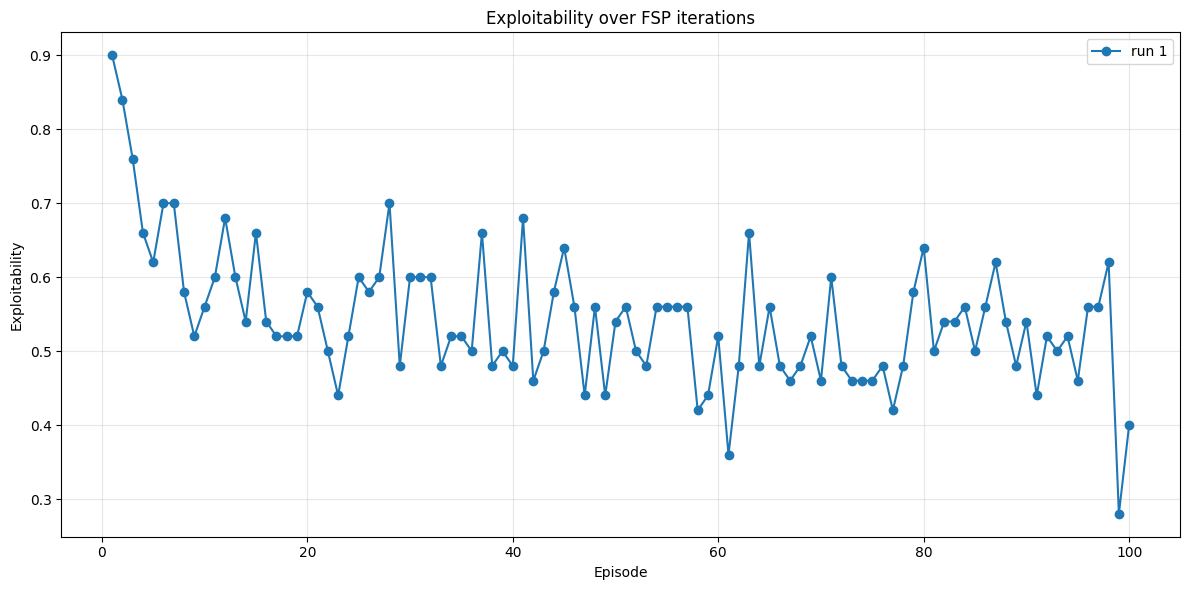

In [75]:
fsp_spec = GameSpec(ranks=3, suits=2, hand_size=1, claim_kinds=("RankHigh", "Pair"), suit_symmetry=True)
avg_dense, fsp_logs = dense_fsp_loop(fsp_spec, episodes=100, episodes_test=50, debug=False)
print("Last rollout avg:", fsp_logs["exploitability_series"][-1]["rollout_avg"])
plot_exploitability_series(fsp_logs)


## Policy Persistence
Save/load policies via the JSON + NPZ serializer (works for tabular and dense).


In [76]:
save_dir = ARTIFACTS_ROOT / "overview_demo" / "random_policy"
dense_dir = ARTIFACTS_ROOT / "overview_demo" / "dense_policy"
save_dir.mkdir(parents=True, exist_ok=True)
dense_dir.mkdir(parents=True, exist_ok=True)
save_policy(rand_pol, save_dir)
dense_to_save = DenseTabularPolicy(step_spec)
save_policy(dense_to_save, dense_dir)
print("Saved random files:", sorted(os.listdir(save_dir)))
print("Saved dense files:", sorted(os.listdir(dense_dir)))


Saved random files: ['metadata.json']
Saved dense files: ['blobs.npz', 'metadata.json']


In [77]:
loaded, loaded_spec = load_policy(save_dir)
opening_again = InfoSet(pid=0, hand=possible_starting_hands(loaded_spec)[0], history=())
print("Loaded spec equals original:", loaded_spec == step_spec)
print("Loaded policy distribution (opening):", loaded.action_probs(opening_again))
loaded_dense, _ = load_policy(dense_dir)
print("Loaded dense policy type:", type(loaded_dense).__name__)


Loaded spec equals original: True
Loaded policy distribution (opening): {0: 0.1111111111111111, 1: 0.1111111111111111, 2: 0.1111111111111111, 3: 0.1111111111111111, 4: 0.1111111111111111, 5: 0.1111111111111111, 6: 0.1111111111111111, 7: 0.1111111111111111, 8: 0.1111111111111111}
Loaded dense policy type: DenseTabularPolicy


## Evaluation Helpers
Quickly evaluate matchups via sampling and exact tabular evaluation on tiny specs.


In [78]:
seat_eval = eval_seats_split(step_spec, rand_pol, br_once, episodes=200, seed=5)
print("Seat-split win rates (random vs BR):", seat_eval)


Seat-split win rates (random vs BR): {'A_seat1': 0.47, 'A_seat2': 0.56, 'B_seat1': 0.44, 'B_seat2': 0.53}


In [79]:
tab_rand = TabularPolicy(); tab_rand.bind_rules(step_rules)
res_exact = exact_eval_tabular_both_seats(step_spec, tab_rand, policy_exact)
print("Exact evaluation (uniform tabular vs exact BR):", res_exact)


Exact evaluation (uniform tabular vs exact BR): {'P1': 0.5, 'P2': 0.5}


In [80]:
mixed_tab = new_avg.to_tabular()
mixed_tab.bind_rules(avg_rules)
res_mix = exact_eval_tabular_both_seats(avg_spec, mixed_tab, policy_exact)
print("Exact evaluation (mixed vs exact BR on avg_spec):", res_mix)


Exact evaluation (mixed vs exact BR on avg_spec): {'P1': 0.1927407407407407, 'P2': 0.8072592592592593}
